# binary classification example - titanic dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal
from pandas.testing import assert_series_equal
from xgboost import XGBClassifier
import treelite
import treelite_runtime
import dill
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from hyperopt import hp
from hyperopt import tpe
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**Gators** imports

In [4]:
from gators.util import util
# data cleaning
from gators.data_cleaning import (
    ConvertColumnDatatype,
    DropHighNaNRatio,
    DropLowCardinality,
    DropHighCardinality,
    DropDatatypeColumns,
    DropColumns,
    KeepColumns,
    Replace,
)
# imputers
from gators.imputers import (
    NumericsImputer, 
    ObjectImputer,
)
# encoders
from gators.encoders import (
    OrdinalEncoder, 
    WOEEncoder,
    OneHotEncoder
)
# binning
from gators.binning import (
    BinRareCategories,
    Binning,
    CustomBinning,
    QuantileBinning,
    TreeBinning,
)
# feature generation
from gators.feature_generation import (
    PolynomialFeatures,
    ElementaryArithmetics,
    PolynomialObjectFeatures,
)
from gators.feature_generation_str import (
    StringContains,
    StringLength,
    Extract,
    SplitExtract,
)
# feature selection
from gators.feature_selection import (
    SelectFromModel,
    InformationValue
)
# model building
from gators.model_building import (
    TrainTestSplit,
    HyperOpt,
    XGBBoosterBuilder,
    XGBTreeliteDumper,
)
# pipeline
from gators.pipeline import Pipeline

## offline pipeline - feature selection

In [5]:
data = pd.read_parquet('data/titanic.parquet')
data = data.reset_index(drop=True)
y = data['Survived']
X = data.drop('Survived', axis=1)
train_test_split = TrainTestSplit(test_ratio=0.3, strategy='ordered')
X_train, X_test, y_train, y_test = train_test_split.transform(X, y)

In [6]:
from pandas_profiling import ProfileReport
profile = ProfileReport(
    pd.concat([X_train, y_train], axis=1),
    title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
label_counts = data['Survived'].value_counts(normalize=True).sort_values().iloc[::-1]
label_counts.plot(
    kind='barh', 
    figsize=(4, 3), 
    title='Label Distribution',
);

### offline pipeline - data preprocessing & feature selection

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0)

[Text(167.4, 181.2, 'Age <= 6.0\nentropy = 0.967\nsamples = 624\nvalue = [378, 246]'),
 Text(83.7, 108.72, 'Age <= 0.96\nentropy = 0.907\nsamples = 31\nvalue = [10, 21]'),
 Text(41.85, 36.23999999999998, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(125.55000000000001, 36.23999999999998, 'entropy = 0.94\nsamples = 28\nvalue = [10, 18]'),
 Text(251.10000000000002, 108.72, 'Age <= 63.5\nentropy = 0.958\nsamples = 593\nvalue = [368, 225]'),
 Text(209.25, 36.23999999999998, 'entropy = 0.962\nsamples = 584\nvalue = [359, 225]'),
 Text(292.95, 36.23999999999998, 'entropy = 0.0\nsamples = 9\nvalue = [9, 0]')]

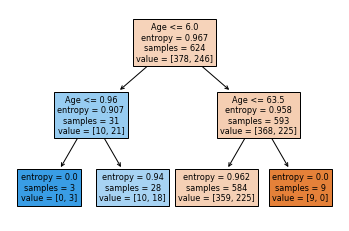

In [85]:
dt = DecisionTreeClassifier(random_state=0, max_depth=2, criterion='entropy')
dt.fit(X_train[['Age']].fillna(X_train[['Age']].mean()), y_train)
tree.plot_tree(dt, feature_names=['Age'], filled=True)

In [121]:
k = 12
model = XGBClassifier(
    random_state=0, 
    eval_metric='logloss', 
)
offline_steps = [
    SplitExtract(['Name'], [', '], [1], ['Dummy']),
    SplitExtract(['Dummy'], ['.'], [0], ['Title']),
    DropColumns(['Ticket', 'Name', 'Dummy', 'Cabin']),
    BinRareCategories(min_ratio=0.05),
    ObjectImputer(strategy='constant', value='MISSING'),
    Replace(
        to_replace_dict={'Title': {'Ms': 'Miss', 'Mme': 'Mrs', 'Mlle': 'Miss'}}
    ),
    NumericsImputer(columns=['Age', 'Fare'], strategy='mean'),
    NumericsImputer(columns=['SibSp', 'Parch'], strategy='most_frequent'),
    ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilySize']),
#     TreeBinning(max_depth=2, inplace=True),
#     Replace(
#         to_replace_dict={
#             'Fare': {
#                 '_0': 'VerySmallFare', 
#                 '_1': 'SmallFare', 
#                 '_2': 'NormalFare', 
#                 '_3': 'ExpensiveFare'},
#             'Age': {'_0': 'Young', '_1': 'YoungAdult', '_2': 'Adult', '_3': 'Senior'},
#             'Pclass': {'_0': '1stClass', '_1': '2ndClass', '_2': '3rdClass'},
#             'FamilySize': {
#                 '_0': 'NoFamily',
#                 '_1': 'SmallFamily', 
#                 '_2': 'BigFamily'},
#             'Sex': {'female': 'Woman', 'male': 'Man'}
#         }
#     ),
    DropColumns(['Sex', 'SibSp', 'Parch']),
#     PolynomialObjectFeatures(
#         columns=['Title', 'Pclass', 'Age', 'Fare', 'Embarked', 'FamilySize'],
#         degree=2),
    
#     BinRareCategories(min_ratio=0.05),
#     InformationValue(binning=TreeBinning(max_depth=2, inplace=True), k=k)
]
offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro = offline_pipe.fit_transform(X_train, y_train)
# features = list(X_train_prepro.columns)

In [122]:
i = [262, 193, 315, 33, 297]
X_train_prepro.iloc[i]

,Pclass,Age,Fare,Embarked,Title,FamilySize
262,1,52.0,79.6500,S,Mr,2.0
193,2,3.0,26.0000,S,OTHERS,2.0
315,3,26.0,7.8542,S,Miss,0.0
33,2,66.0,10.5000,S,Mr,0.0
297,1,2.0,151.5500,S,Miss,3.0


In [126]:
k = 12
model = XGBClassifier(
    random_state=0, 
    eval_metric='logloss', 
)
offline_steps = [
    SplitExtract(['Name'], [', '], [1], ['Dummy']),
    SplitExtract(['Dummy'], ['.'], [0], ['Title']),
    DropColumns(['Ticket', 'Name', 'Dummy', 'Cabin']),
    BinRareCategories(min_ratio=0.05),
    ObjectImputer(strategy='constant', value='MISSING'),
    Replace(
        to_replace_dict={'Title': {'Ms': 'Miss', 'Mme': 'Mrs', 'Mlle': 'Miss'}}
    ),
    NumericsImputer(columns=['Age', 'Fare'], strategy='mean'),
    NumericsImputer(columns=['SibSp', 'Parch'], strategy='most_frequent'),
    ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilySize']),
    TreeBinning(max_depth=2, inplace=True),
    Replace(
        to_replace_dict={
            'Fare': {
                '_0': 'VerySmallFare', 
                '_1': 'SmallFare', 
                '_2': 'NormalFare', 
                '_3': 'ExpensiveFare'},
            'Age': {'_0': 'Baby', '_1': 'Young', '_2': 'Adult', '_3': 'Senior'},
            'Pclass': {'_0': '1stClass', '_1': '2ndClass', '_2': '3rdClass'},
            'FamilySize': {
                '_0': 'NoFamily',
                '_1': 'SmallFamily', 
                '_2': 'BigFamily'},
            'Sex': {'female': 'Woman', 'male': 'Man'}
        }
    ),
    DropColumns(['Sex', 'SibSp', 'Parch']),
    PolynomialObjectFeatures(
        columns=['Title', 'Pclass', 'Age', 'Fare', 'Embarked', 'FamilySize'],
        degree=2),
    
#     BinRareCategories(min_ratio=0.05),
#     InformationValue(binning=TreeBinning(max_depth=2, inplace=True), k=k)
]
offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro = offline_pipe.fit_transform(X_train, y_train)
# features = list(X_train_prepro.columns)

In [124]:
X_train_prepro[X_train_prepro['Age'] == 'Senior']

,Pclass,Age,Fare,Embarked,Title,FamilySize
33,2ndClass,Senior,NormalFare,S,Mr,NoFamily
54,1stClass,Senior,ExpensiveFare,C,Mr,SmallFamily
96,1stClass,Senior,NormalFare,C,Mr,NoFamily
116,3rdClass,Senior,SmallFare,Q,Mr,NoFamily
280,3rdClass,Senior,SmallFare,Q,Mr,NoFamily
438,1stClass,Senior,ExpensiveFare,S,Mr,BigFamily
456,1stClass,Senior,NormalFare,S,Mr,NoFamily
493,1stClass,Senior,NormalFare,C,Mr,NoFamily
545,1stClass,Senior,NormalFare,S,Mr,NoFamily


In [135]:
i = [262, 193, 315, 33, 297]
X_train_prepro[[ 'Age', 'Fare', 'Title', 'FamilySize', 'Title__Pclass',
 'Title__Age',
 'Title__FamilySize',
 'Age__Fare',
 'Age__FamilySize',
               ]].iloc[i]

,Age,Fare,Title,FamilySize,Title__Pclass,Title__Age,Title__FamilySize,Age__Fare,Age__FamilySize
262,Adult,ExpensiveFare,Mr,SmallFamily,Mr1stClass,MrAdult,MrSmallFamily,AdultExpensiveFare,AdultSmallFamily
193,Young,NormalFare,OTHERS,SmallFamily,OTHERS2ndClass,OTHERSYoung,OTHERSSmallFamily,YoungNormalFare,YoungSmallFamily
315,Adult,SmallFare,Miss,NoFamily,Miss3rdClass,MissAdult,MissNoFamily,AdultSmallFare,AdultNoFamily
33,Senior,NormalFare,Mr,NoFamily,Mr2ndClass,MrSenior,MrNoFamily,SeniorNormalFare,SeniorNoFamily
297,Baby,ExpensiveFare,Miss,SmallFamily,Miss1stClass,MissBaby,MissSmallFamily,BabyExpensiveFare,BabySmallFamily


In [133]:
[c for c in X_train_prepro.columns if '__' in c]

['Title__Pclass',
 'Title__Age',
 'Title__Fare',
 'Title__Embarked',
 'Title__FamilySize',
 'Pclass__Age',
 'Pclass__Fare',
 'Pclass__Embarked',
 'Pclass__FamilySize',
 'Age__Fare',
 'Age__Embarked',
 'Age__FamilySize',
 'Fare__Embarked',
 'Fare__FamilySize',
 'Embarked__FamilySize']

In [11]:
for c in [c for c in X_train_prepro.columns if '__' not in c]:
    pd.crosstab(X_train_prepro[c], y_train, normalize='all').sort_values(0)

Survived,0,1
Fare,,
OTHERS,0.038462,0.001603
ExpensiveFare,0.052885,0.113782
SmallFare,0.254808,0.078526
NormalFare,0.259615,0.200321


Survived,0,1
Title,,
Mrs,0.028846,0.113782
OTHERS,0.033654,0.030449
Miss,0.064103,0.158654
Mr,0.479167,0.091346


In [76]:
k = 12
model = XGBClassifier(
    random_state=0, 
    eval_metric='logloss', 
)
degree = 2
offline_steps = [
    SplitExtract(['Name'], [', '], [1], ['Dummy']),
    SplitExtract(['Dummy'], ['.'], [0], ['Title']),
    DropColumns(['Ticket', 'Name', 'Dummy', 'Cabin']),
    BinRareCategories(min_ratio=0.05),
    ObjectImputer(strategy='constant', value='MISSING'),
    Replace(
        to_replace_dict={'Title': {'Ms': 'Miss', 'Mme': 'Mrs', 'Mlle': 'Miss'}}
    ),
    NumericsImputer(columns=['Age', 'Fare'], strategy='mean'),
    NumericsImputer(columns=['SibSp', 'Parch'], strategy='most_frequent'),
    ElementaryArithmetics(
        operator='+',
        columns_a=['SibSp'], 
        columns_b=['Parch'], 
        column_names=['FamilySize']),
    TreeBinning(max_depth=2, inplace=True),
    Replace(
        to_replace_dict={
            'Fare': {
                '_0': 'VerySmallFare', 
                '_1': 'SmallFare', 
                '_2': 'StandardFare', 
                '_3': 'ExpensiveFare'},
            'Age': {'_0': 'Young', '_1': 'YoungAdult', '_2': 'Adult', '_3': 'Senior'},
            'Pclass': {'_0': '1stClass', '_1': '2ndClass', '_2': '3rdClass'},
            'FamilySize': {
                '_0': 'NoFamily',
                '_1': 'SmallFamily', 
                '_2': 'BigFamily'},
            'Sex': {'female': 'Woman', 'male': 'Man'}
        }
    ),
    DropColumns(['Sex']),
    PolynomialObjectFeatures(
        columns=['Title', 'Pclass', 'Age', 'Fare', 'Embarked', 'FamilySize'],
        degree=degree),
    
#     BinRareCategories(min_ratio=0.05),
    InformationValue(binning=TreeBinning(max_depth=2, inplace=True), k=100),
#     WOEEncoder()
]
offline_pipe = Pipeline(steps=offline_steps)
X_train_prepro = offline_pipe.fit_transform(X_train, y_train)
# features = list(X_train_prepro.columns)

In [77]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(
#     pd.concat([X_train_prepro, y_train], axis=1),
#     title="Pandas Profiling Report")
# profile

In [139]:
import seaborn as sns
cm = sns.light_palette("blue", as_cmap=True)

df2.style.background_gradient(cmap=cm)


NameError: name 'df2' is not defined

In [147]:
cm = sns.color_palette("vlag", as_cmap=True)


for d in range(degree):
    print('DEGREE', d)
    for c in [c for c in X_train_prepro.columns if c.count('__') == d]:
        pd.crosstab(X_train_prepro[c], y_train, normalize='index').sort_values(0).style.background_gradient(
            cmap=cm, vmin=0, vmax=1)

DEGREE 0


Survived,0,1
Pclass,,
1stClass,0.400000,0.600000
2ndClass,0.484615,0.515385
3rdClass,0.741279,0.258721


Survived,0,1
Age,,
Young,0.200000,0.800000
Baby,0.437500,0.562500
Adult,0.614726,0.385274
Senior,1.000000,0.000000


Survived,0,1
Fare,,
ExpensiveFare,0.317308,0.682692
NormalFare,0.564460,0.435540
SmallFare,0.764423,0.235577
VerySmallFare,0.960000,0.040000


Survived,0,1
Embarked,,
OTHERS,0.000000,1.000000
C,0.471074,0.528926
Q,0.535714,0.464286
S,0.652466,0.347534


Survived,0,1
Title,,
Mrs,0.202247,0.797753
Miss,0.287770,0.712230
OTHERS,0.525000,0.475000
Mr,0.839888,0.160112


Survived,0,1
FamilySize,,
SmallFamily,0.432558,0.567442
NoFamily,0.682192,0.317808
BigFamily,0.818182,0.181818


DEGREE 1


Survived,0,1
Title__Pclass,,
Mrs1stClass,0.035714,0.964286
Miss1stClass,0.055556,0.944444
Mrs2ndClass,0.066667,0.933333
Miss2ndClass,0.074074,0.925926
OTHERS1stClass,0.333333,0.666667
OTHERS2ndClass,0.416667,0.583333
Miss3rdClass,0.473684,0.526316
Mrs3rdClass,0.483871,0.516129
OTHERS3rdClass,0.684211,0.315789


Survived,0,1
Title__Age,,
MissYoung,0.125000,0.875000
MrsAdult,0.202247,0.797753
OTHERSYoung,0.285714,0.714286
MissAdult,0.292683,0.707317
MissBaby,0.375000,0.625000
OTHERSBaby,0.500000,0.500000
OTHERSAdult,0.600000,0.400000
MrAdult,0.835735,0.164265
MrSenior,1.000000,0.000000


Survived,0,1
Title__Fare,,
MrsExpensiveFare,0.041667,0.958333
MissExpensiveFare,0.058824,0.941176
MrsNormalFare,0.237288,0.762712
MissNormalFare,0.311475,0.688525
OTHERSExpensiveFare,0.333333,0.666667
MissSmallFare,0.431818,0.568182
MrsSmallFare,0.500000,0.500000
OTHERSNormalFare,0.558824,0.441176
MrExpensiveFare,0.700000,0.300000


Survived,0,1
Title__Embarked,,
MissOTHERS,0.000000,1.000000
MrsQ,0.000000,1.000000
MrsC,0.120000,0.880000
MissC,0.148148,0.851852
MissQ,0.148148,0.851852
OTHERSC,0.166667,0.833333
MrsS,0.238095,0.761905
MissS,0.380952,0.619048
OTHERSS,0.533333,0.466667


Survived,0,1
Title__FamilySize,,
MrsNoFamily,0.071429,0.928571
OTHERSSmallFamily,0.117647,0.882353
MissSmallFamily,0.195652,0.804348
MrsSmallFamily,0.200000,0.800000
MissNoFamily,0.250000,0.750000
MrsBigFamily,0.600000,0.400000
OTHERSNoFamily,0.666667,0.333333
MissBigFamily,0.705882,0.294118
MrSmallFamily,0.829268,0.170732


Survived,0,1
Pclass__Age,,
1stClassYoung,0.000000,1.000000
2ndClassBaby,0.000000,1.000000
2ndClassYoung,0.000000,1.000000
3rdClassYoung,0.333333,0.666667
1stClassAdult,0.375887,0.624113
1stClassBaby,0.500000,0.500000
2ndClassAdult,0.516667,0.483333
3rdClassBaby,0.600000,0.400000
3rdClassAdult,0.755418,0.244582


Survived,0,1
Pclass__Fare,,
1stClassExpensiveFare,0.268817,0.731183
2ndClassNormalFare,0.459016,0.540984
1stClassNormalFare,0.607143,0.392857
3rdClassNormalFare,0.660550,0.339450
3rdClassExpensiveFare,0.714286,0.285714
2ndClassExpensiveFare,0.750000,0.250000
3rdClassSmallFare,0.764423,0.235577
3rdClassVerySmallFare,0.950000,0.050000
1stClassVerySmallFare,1.000000,0.000000


Survived,0,1
Pclass__Embarked,,
1stClassOTHERS,0.000000,1.000000
2ndClassQ,0.000000,1.000000
1stClassC,0.333333,0.666667
1stClassS,0.452381,0.547619
2ndClassS,0.491379,0.508621
1stClassQ,0.500000,0.500000
2ndClassC,0.500000,0.500000
3rdClassQ,0.557692,0.442308
3rdClassC,0.652174,0.347826


Survived,0,1
Pclass__FamilySize,,
2ndClassBigFamily,0.000000,1.000000
1stClassSmallFamily,0.287671,0.712329
2ndClassSmallFamily,0.345455,0.654545
1stClassBigFamily,0.400000,0.600000
1stClassNoFamily,0.513889,0.486111
2ndClassNoFamily,0.594595,0.405405
3rdClassSmallFamily,0.609195,0.390805
3rdClassNoFamily,0.767123,0.232877
3rdClassBigFamily,0.894737,0.105263


Survived,0,1
Age__Fare,,
YoungExpensiveFare,0.000000,1.000000
YoungNormalFare,0.214286,0.785714
AdultExpensiveFare,0.303030,0.696970
BabyNormalFare,0.384615,0.615385
BabyExpensiveFare,0.500000,0.500000
AdultNormalFare,0.584314,0.415686
AdultSmallFare,0.760976,0.239024
AdultVerySmallFare,0.960000,0.040000
BabySmallFare,1.000000,0.000000


Survived,0,1
Age__Embarked,,
AdultOTHERS,0.000000,1.000000
BabyC,0.000000,1.000000
YoungC,0.000000,1.000000
YoungS,0.166667,0.833333
BabyS,0.461538,0.538462
AdultC,0.473684,0.526316
AdultQ,0.500000,0.500000
AdultS,0.669065,0.330935
BabyQ,1.000000,0.000000


Survived,0,1
Age__FamilySize,,
YoungSmallFamily,0.000000,1.000000
BabySmallFamily,0.181818,0.818182
AdultSmallFamily,0.466321,0.533679
YoungBigFamily,0.600000,0.400000
AdultNoFamily,0.675978,0.324022
AdultBigFamily,0.818182,0.181818
BabyBigFamily,1.000000,0.000000
SeniorBigFamily,1.000000,0.000000
SeniorNoFamily,1.000000,0.000000


Survived,0,1
Fare__Embarked,,
ExpensiveFareOTHERS,0.000000,1.000000
ExpensiveFareC,0.212766,0.787234
ExpensiveFareS,0.407407,0.592593
NormalFareQ,0.466667,0.533333
ExpensiveFareQ,0.500000,0.500000
SmallFareQ,0.540541,0.459459
NormalFareC,0.551020,0.448980
NormalFareS,0.573991,0.426009
SmallFareC,0.791667,0.208333


Survived,0,1
Fare__FamilySize,,
SmallFareBigFamily,0.000000,1.000000
ExpensiveFareNoFamily,0.250000,0.750000
ExpensiveFareSmallFamily,0.298507,0.701493
NormalFareSmallFamily,0.429688,0.570312
NormalFareNoFamily,0.616000,0.384000
ExpensiveFareBigFamily,0.666667,0.333333
SmallFareNoFamily,0.756614,0.243386
NormalFareBigFamily,0.882353,0.117647
SmallFareSmallFamily,0.888889,0.111111


Survived,0,1
Embarked__FamilySize,,
CBigFamily,0.000000,1.000000
OTHERSNoFamily,0.000000,1.000000
CSmallFamily,0.350000,0.650000
QSmallFamily,0.461538,0.538462
SSmallFamily,0.464789,0.535211
QNoFamily,0.525000,0.475000
CNoFamily,0.600000,0.400000
SNoFamily,0.727273,0.272727
SBigFamily,0.825000,0.175000


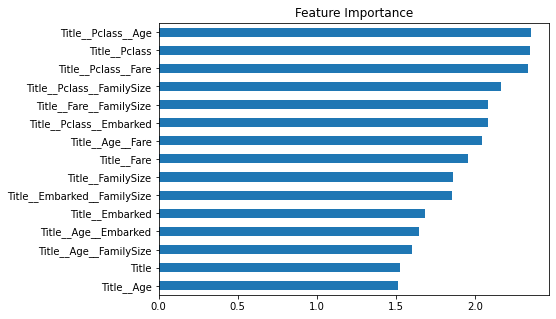

In [63]:
%matplotlib inline
offline_pipe.get_feature_importances(k=15)[::-1].plot(
    kind='barh', 
    figsize=(7, 5), 
    title='Feature Importance',
);

In [64]:
offline_pipe.get_feature_importances(k=15)

Title__Pclass__Age             2.347859
Title__Pclass                  2.342039
Title__Pclass__Fare            2.329891
Title__Pclass__FamilySize      2.160092
Title__Fare__FamilySize        2.080397
Title__Pclass__Embarked        2.080134
Title__Age__Fare               2.043922
Title__Fare                    1.954942
Title__FamilySize              1.860541
Title__Embarked__FamilySize    1.853864
Title__Embarked                1.682438
Title__Age__Embarked           1.644903
Title__Age__FamilySize         1.598148
Title                          1.524339
Title__Age                     1.510063
dtype: float64